<div id="reminder" style="border-radius: 5px; background-color:#f5f5f5; padding: 15px 5px; " >
<p>Use this notebook to follow along with the lab tutorial.</p>
</div>

# <font color="blue">Lesson 3 Feature Engineering and Selection</font>

<hr style="border:5px solid gray"> </hr>

## Section 1 Handling Categorical Variables

<hr style="border:5px solid gray"> </hr>

In this notebook we cover examples of common feature engineering tasks on both numeric and categorical data. The goal isn't to be exhaustive, but provide you with enough examples that you can get the picture.

We begin with numeric features. Let's begin by reading some data.

### Read Data from CSV File

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

file = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/Tennis.csv"
data = pd.read_csv(file, header=0)
print(data.shape)
data.head()

(14, 5)


,outlook,temp,humidity,windy,play
0,sunny,hot,high,strong,no
1,sunny,hot,high,weak,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes


In [2]:
!pip install category_encoders

    100% |████████████████████████████████| 81kB 306kB/s ta 0:00:011
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### One Hot Encoding

In [3]:
import category_encoders as ce
X = data[["outlook","temp","humidity","windy"]]
le =  ce.OneHotEncoder(return_df=False, handle_unknown="ignore")
X_encoded = le.fit_transform(X)
X_encoded[0:5,:]

/Users/roblisy/.pyenv/versions/3.7.0/envs/uw_data_sci/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


array([[1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 1, 0, 1]])

### One-hot Encoding by Pandas


Here we will use pandas `get_dummies()` function.

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

Note that the default `drop_first=False` option will give a column for each n factors, but the `drop_first=True` will not create a column for the first instance, resulting in n-1 columns.

In [4]:
import pandas as pd
data_encoded = pd.get_dummies(data, columns=["outlook","temp","humidity","windy"], \
                             prefix=["outlook","temp","humdity","windy"])
data_encoded.head()

,play,outlook_overcast,outlook_rain,outlook_sunny,temp_cool,temp_hot,temp_mild,humdity_high,humdity_normal,windy_strong,windy_weak
0,no,0,0,1,0,1,0,1,0,1,0
1,no,0,0,1,0,1,0,1,0,0,1
2,yes,1,0,0,0,1,0,1,0,0,1
3,yes,0,1,0,0,0,1,1,0,0,1
4,yes,0,1,0,1,0,0,0,1,0,1


### References for More Complete List of One-hot Encoding Methodologies

Moffitt, C. (2017) <a href="http://pbpython.com/categorical-encoding.html">Guide to Encoding Categorical Values in Python</a>, Practical Business Python.

### Risk Values of Categorical Variables

In [5]:
import numpy as np

# Probability of 'yes' overall= proportion of 'yes'
general_prob = (data.iloc[:,4] == "yes").sum()/float(data.shape[0])

# Initialize variable mapping dictionary.
variable_risks = {}
for variable in ['outlook', 'temp', 'humidity', 'windy']:
    
    # Create a contingency table: just a table of counts
    tab = pd.crosstab(data[variable], data.play)
    
    # The numer of rows in the prior table is equal to the number of different levels.
    num_levels = tab.shape[0]
    
    # Initialize our mapping dictionary for each level.
    level_risk = {}
    # Get a list of levels
    levels = list(tab.index)
    # Fill out level risk for the variable selected (iterate through each level)
    for level_index, lev in enumerate(levels):
        # Some conversion for booleans to strings necessary for dictionary keys.
        if lev == True:
            lev = 'True'
        elif lev == False:
            lev = 'False'
        # general_prob is p(outcome=1), so p(outcome=0) = 1-general_prob, these are added as "Smoothing" for risk.
        #     (Also prevents divide by zero)
        level_risk[lev] = np.log((tab.iloc[level_index, 1] + general_prob) /
                                 (tab.iloc[level_index, 0] + 1 - general_prob))

    variable_risks[variable] = level_risk
print(json.dumps(variable_risks, indent=2))

{
  "outlook": {
    "overcast": 2.564949357461537,
    "rain": 0.4353180712578455,
    "sunny": -0.23922968906583425
  },
  "temp": {
    "cool": 0.9873866535578852,
    "hot": 0.11441035117774412,
    "mild": 0.6778797084291569
  },
  "humidity": {
    "high": -0.17904823144898543,
    "normal": 1.5881605139868153
  },
  "windy": {
    "strong": 0.0816780310142671,
    "weak": 1.0360919316867758
  }
}


### Replace the Original Categorical Values with Risks

In [7]:
data_risks = data.copy()
# data_risks.windy = data_risks.windy.astype(float)
num_obs = data.shape[0]
for variable in ['outlook', 'temp', 'humidity', 'windy']:
    for i in range(num_obs):
        if data[variable][i] == True:
            lev = 'True'
        elif data[variable][i] == False:
            lev = 'False'
        else:
            lev = data[variable][i]
        data_risks[variable][i] = variable_risks[variable][lev]
data_risks.head()

,outlook,temp,humidity,windy,play
0,-0.23923,0.11441,-0.179048,0.081678,no
1,-0.23923,0.11441,-0.179048,1.03609,no
2,2.56495,0.11441,-0.179048,1.03609,yes
3,0.435318,0.67788,-0.179048,1.03609,yes
4,0.435318,0.987387,1.58816,1.03609,yes


<hr style="border:2px solid gray"> </hr>

Example 2: Auto MPG dataset

<hr style="border:2px solid gray"> </hr>

Dataset in canvas.

Information here:
https://www.kaggle.com/uciml/autompg-dataset

In [8]:
auto = pd.read_csv('auto-mpg.csv')
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [9]:
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

We can see that we have quite a few numeric columns in here. However, we also need to be careful: a column like `cylinders` looks numeric, but probably should be treated as a categorical column. Why? As yourself which one of these two is more likely:

- do any kind of math with `cylinders`, such as taking the log of it, adding it to another column, or being interested in knowing the average number of cylinders?
- use cylinder as a grouping variable, such as wanting to see the average horsepower **by cylinder**?

We can probably agree that the second case is more likely. For this reason, we need convert cylinder into a categorical column. More on categorical columns in the next lesson.

In [10]:
auto['cylinders'] = auto['cylinders'].astype('category')

None of the feature seem to have any extreme values. Let's check for missing values. To see if any columns in the data are missing, we can use the `isnull` method, followed by `any` where the `axis = 0` is used to ask if **any** of values **across columns** is null: `False` means that none is missing, and `True` means that at least one value is missing.

In [11]:
auto.isnull().any(axis = 0)

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name        False
dtype: bool

In [12]:
auto.isnull().sum(axis = 0)

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

Note that all of this would work only if the missing data is properly marked as null. Often when reading external data sources, other conventions are used to mark data as missing, such as using `-999` for numeric data, or the string `NA` or `?` or the empty string for categorical data. Such values by default would not be picked up by `isnull()`. So we would need to first recode them (or overwrite them) with `np.nan`.


### Create Missing Data

Let's illustrate the above point with an example, let's intentially introduce a few missing values in the data, but using characters that won't be recognized as such.

In [13]:
auto.loc[2, ['mpg', 'car name']] = [-999, ""] # make mpg and car_name in the 3st row NA
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,-999.0,8,318.0,150,3436,11.0,70,1,
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [14]:
auto.isnull().any(axis = 0)

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name        False
dtype: bool

In [15]:
# Fix the "missing values" to actually contain np.nan
auto.loc[2, ['mpg', 'car name']] = [np.nan, np.nan]

# Or in general:
auto['mpg'] = auto['mpg'].replace({-999: np.nan})
auto['car name'] = auto['car name'].replace({'': np.nan})

auto.isnull().any(axis = 0)

mpg              True
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name         True
dtype: bool

In [16]:
# Which rows have ANY missing values?
auto[auto.isnull().any(axis = 1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
2,NaN,8,318.0,150,3436,11.0,70,1,NaN


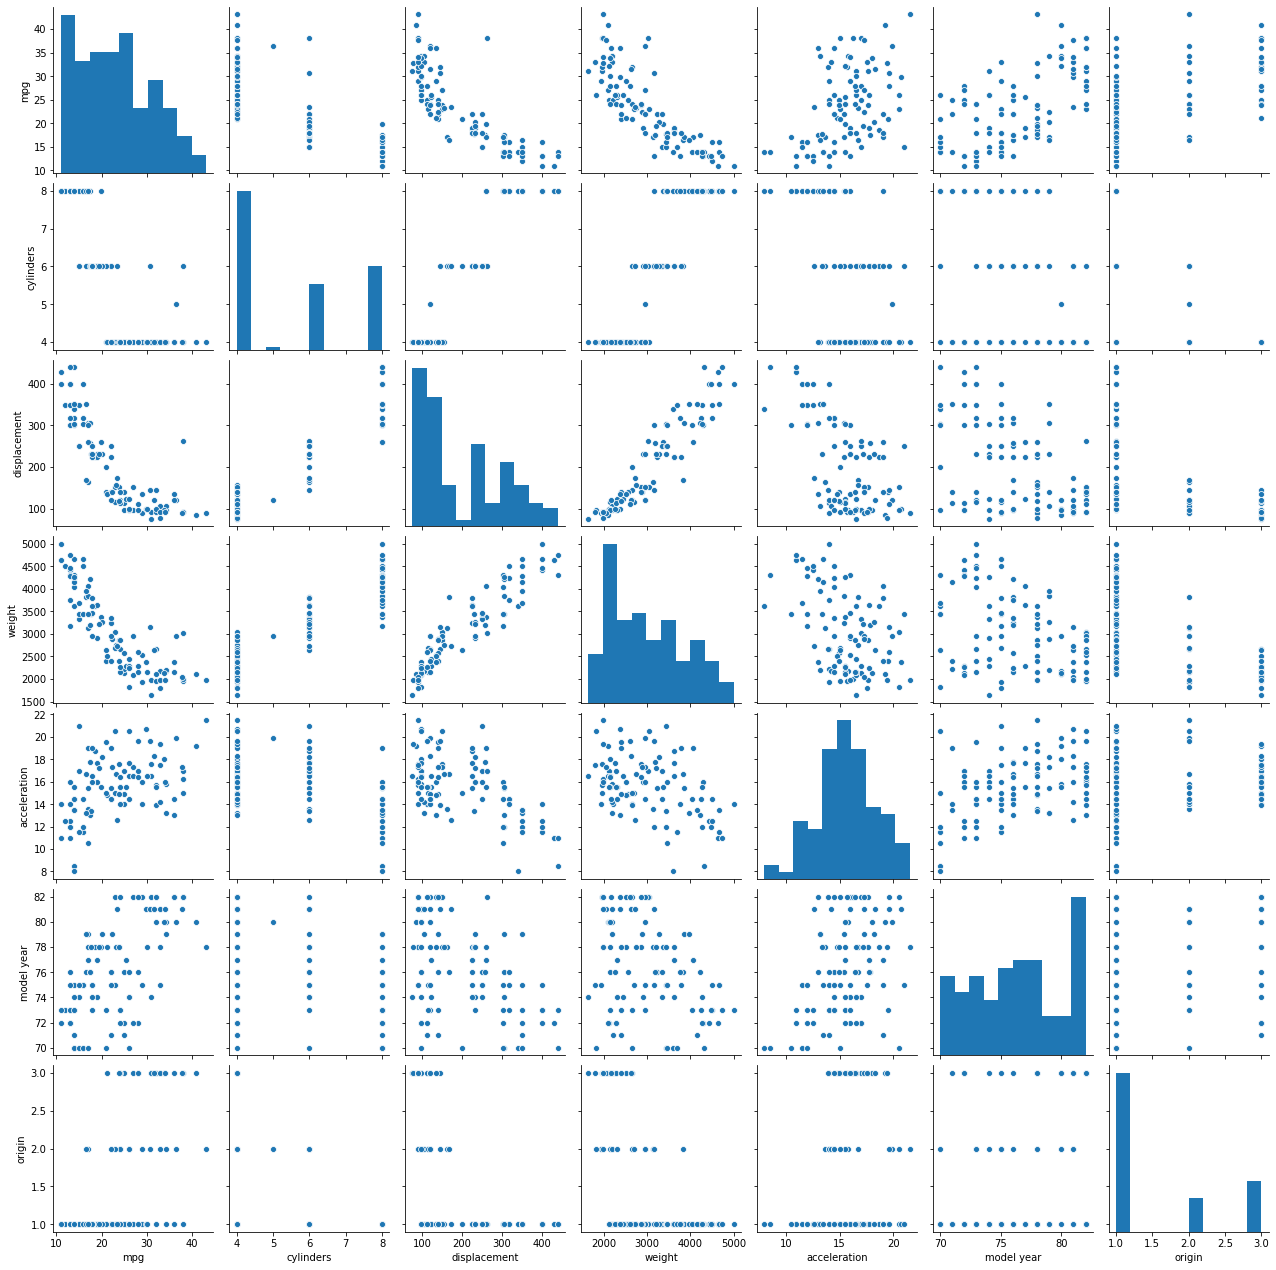

In [17]:
# Paired Plot
sns.pairplot(auto.sample(100));

Let's look at some summary statistics:

In [18]:
auto.describe()

,mpg,displacement,weight,acceleration,model year,origin
count,397.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.528463,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.820926,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,455.000000,5140.000000,24.800000,82.000000,3.000000


Looking at percentiles helps us get a feel for the distribution of the data. For example, looking at very low or very high percentiles can help us identify outliers or extreme values. We can use the quantile method to get any percentile we want. Here's how:

In [19]:
percentiles = [0, 0.05, 0.50, 0.95, 1]
auto.groupby('cylinders')[['mpg', 'displacement']].quantile(q = percentiles)

mpg  displacement
cylinders                           
3         0.00  18.000          70.0
          0.05  18.150          70.0
          0.50  20.250          70.0
          0.95  23.370          78.5
          1.00  23.700          80.0
4         0.00  18.000          68.0
          0.05  21.015          79.0
          0.50  28.250         105.0
          0.95  39.085         151.0
          1.00  46.600         156.0
5         0.00  20.300         121.0
          0.05  20.810         122.0
          0.50  25.400         131.0
          0.95  35.300         177.8
          1.00  36.400         183.0
6         0.00  15.000         145.0
          0.05  16.000         156.0
          0.50  19.000         228.0
          0.95  26.590         258.0
          1.00  38.000         262.0
8         0.00   9.000         260.0
          0.05  11.000         302.0
          0.50  14.000         350.0
          0.95  19.875         438.9
          1.00  26.600         455.0

### Binning Numerical Variables

Let's bin the `mpg` using the `pd.cut` function and specify the cut-offs using the `bins` argument.

In [20]:
auto['mpg_cat'] = pd.cut(auto['mpg'], bins = [0, 18, 25, 100])
auto[['mpg', 'mpg_cat']].head()

,mpg,mpg_cat
0,18.0,"(0.0, 18.0]"
1,15.0,"(0.0, 18.0]"
2,NaN,NaN
3,16.0,"(0.0, 18.0]"
4,17.0,"(0.0, 18.0]"


In [21]:
# Get value counts
auto['mpg_cat'].value_counts(dropna = False)

(25.0, 100.0]    158
(0.0, 18.0]      123
(18.0, 25.0]     116
NaN                1
Name: mpg_cat, dtype: int64

### Exercise

Let's create `mpg_cat` again, but make the following changes to it: 

- Note that the choice of using 0 and 100 as the lower and upper bounds is a little arbitrary. So use `-np.Inf` and `np.Inf` instead.
- By default, cut labels the catgories based on the interval range it covers, but we can change the labels to anything we like using the `labels` argument. Rename the labels to `low`, `med` and `high`.

Documentation:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

In [24]:
auto['mpg_cat'] = pd.cut(auto['mpg'], bins = [-np.Inf, 18, 25, np.Inf], labels = ['low', 'med', 'high'])
auto['mpg_cat'].value_counts()

high    158
low     123
med     116
Name: mpg_cat, dtype: int64

### Standardization and Normalization

Important!

Since normalization is a very common task, you shoudn't be surprised to find out that there is already a function for doing this. I hope you still found the previous exercise useful!

However, this time we have to go to the `sklearn` library to find our function. The `sklearn` library is Python's most common machine learning library and one that we will return to in future lectures. In addition to the machine learning algorithms we will learn about, `sklearn` also has functions for **pre-processing data**, which is a vague term that includes tasks such as missing-value imputation, feature engineering and so on. Let's see how we can use it to normalize our data.

There's one important thing to note about `sklearn` before we continue: We just saw how we can use `pandas` to do data pre-processing and feature engineering, now we're going to see how we can use `sklearn`. When using `pandas` transformation on a `DataFrame` return a `DataFrame` and everything is relatively easy. But with `sklearn` transformations don't return nice-looking `DataFrame` objects. Instead they return `numpy` arrays, so it's up to us to convert the arrays back into `DataFrame` if we need to. In **production** we usually wouldn't need to do that, since we can pass the arrays directly to the ML algorithm for training and for scoring. But during **development** it can help us trace our steps and see intermediate results as we work toward the final product.

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define numeric columns
num_cols = ['mpg', 'displacement', 'weight', 'acceleration']

num_cols_norm = [c + '_norm' for c in num_cols] # names of transformed columns

At first inspection, this code might look a little strange, but this pattern as we will see is very common to ML-related tasks in `sklearn`:
- initialize the process by choosing the function (with arguments we wish, if any)
- run `fit` first on the data, followed by `transform` to apply the transformation

In [26]:
# MinMax Scaler --> scales to 0-1 range.
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(auto[num_cols])
auto[num_cols_norm] = pd.DataFrame(minmax_scaler.transform(auto[num_cols]))
auto[num_cols_norm].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,0.239362,0.617571,0.536150,0.238095
1,0.159574,0.728682,0.589736,0.208333
2,NaN,0.645995,0.516870,0.178571
3,0.186170,0.609819,0.516019,0.238095
4,0.212766,0.604651,0.520556,0.148810


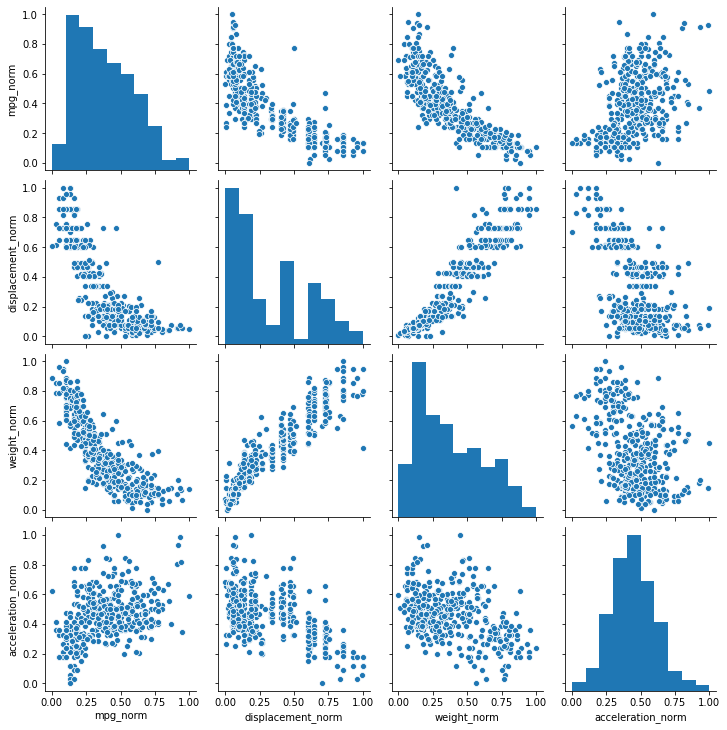

In [27]:
sns.pairplot(auto[num_cols_norm]);

### Z-normal transformation:

In [28]:
znorm_scaler = StandardScaler()
znorm_scaler.fit(auto[num_cols])
auto[num_cols_norm] = pd.DataFrame(znorm_scaler.transform(auto[num_cols]))
auto[num_cols_norm].head()

,mpg_norm,displacement_norm,weight_norm,acceleration_norm
0,-0.707773,1.090604,0.630870,-1.295498
1,-1.091843,1.503514,0.854333,-1.477038
2,NaN,1.196232,0.550470,-1.658577
3,-0.963820,1.061796,0.546923,-1.295498
4,-0.835796,1.042591,0.565841,-1.840117


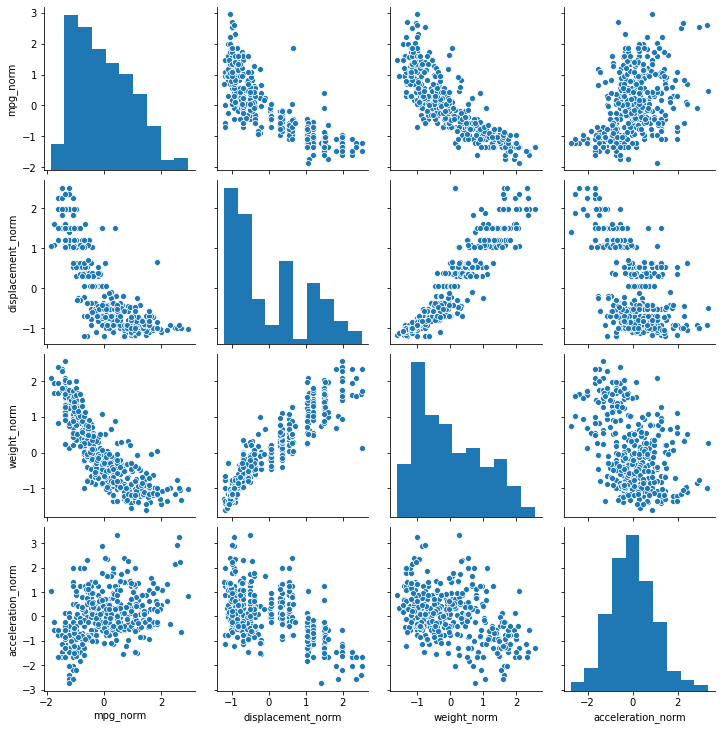

In [29]:
sns.pairplot(auto[num_cols_norm]);

In either case, it doesn't look like normalization did anything to make our scatter plot matrix looks different. Do you notice what changed? The answer is that the **scale of the data** is what changed. Just check the $x$ and $y$ axes and you'll see. Normalization is not really supposed to change the nature of the data, just put all features on the same scale.

<hr style="border:5px solid orange"> </hr>

WARNING:

Your test and validation data should have the SAME EXACT TRANSFORMATIONS applied as the train set.  It is recommended to do:

1. Scale the train set, and you may have to store/remember the mean/variance and other transformation parameters (range etc).
2. Use those exact same scaling parameters applied to train/test.

Why? We don't transform incoming evaluation data by itself.

So:

```
x_train_scaled = my_scaler.fit_transform(x_train)

x_test_scaled = my_scaler.transform(x_test)
x_valid_scaled = my_scaler.transform(x_valid)
```

<hr style="border:5px solid orange"> </hr>

<hr style="border:5px solid gray"> </hr>

## Section 2. Recency, Frequency, and Monetary (RFM)

<hr style="border:5px solid gray"> </hr>

### Read Example Data

In [31]:
import pandas as pd
file = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/Retail_Churn_Data.csv"
data = pd.read_csv(file, sep=",", header=0)
print('Data shape: {}'.format(data.shape))
data.head()

Data shape: (252204, 9)


,UserId,Age,Address,Column 0,TransactionId,Timestamp,ItemId,Quantity,Value
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


### Convert Timestamp to Datetime Object

In [32]:
import datetime as dt
import pandas as pd
import numpy as np
from collections import OrderedDict

data["Timestamp"] = pd.to_datetime(data["Timestamp"], format='%m/%d/%Y %H:%M')
data.head()
print("Minimal Date=%s, Maximal Date=%s"%(min(data["Timestamp"]).strftime("%Y-%m-%d %H:%M"), \
                                          max(data["Timestamp"]).strftime("%Y-%m-%d %H:%M")))

Minimal Date=2000-11-01 00:00, Maximal Date=2001-02-28 00:00


### Calculate RFM Features for Users at Each Checkpoint

In [34]:
Start_Date_Obj = dt.datetime.strptime("1/1/2001", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("1/10/2001", "%m/%d/%Y")
Time_Window = 60 #days. Only consider customers who have activities within the recent 60 days
FM_Window = 7 #days for frequency and monetary

check_point_date = Start_Date_Obj
UserID = []
Checkpoint = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []

while check_point_date <= End_Date_Obj:
    window_start = check_point_date - dt.timedelta(days = Time_Window)
    mask = (data["Timestamp"] >= window_start) & (data["Timestamp"] < check_point_date)
    # Get the data in [checkpoint-60days, checkpoint]
    data_checkpoint = data.loc[mask]
    # Get the ids of users who have activities in [checkpoint-60days, checkpoint]
    unique_users = list(set(data_checkpoint["UserId"]))
    print("There are %d unique users."%(len(unique_users)))
    FM_Window_Start = check_point_date - dt.timedelta(days = FM_Window)
    # Create features for each user. So loop through each user.
    for user in unique_users:
        # Each event has an entry. We start with the user id.
        UserID.append(user)
        # Then we add the "checkpoint date", which is the ending date in the window.
        Checkpoint.append(check_point_date)
        # Create an easy boolean "mask" to indicate which rows apply to the specific user we are looping on.
        mask = data_checkpoint["UserId"] == user
        # Then filter the checkpoint DF for that user.
        data_checkpoint_user = data_checkpoint.loc[mask]
        
        # Here, we calculate the most recent span of time since last user action.
        delta = check_point_date - max(data_checkpoint_user["Timestamp"])
        # Convert that delta to a day count.
        recency = delta.days #Recency, days between checkpoint and last transaction time
        
        # Now we create a new mask to make sure that our following features are IN our window (after start date)
        mask = data_checkpoint_user["Timestamp"] >= FM_Window_Start
        data_checkpoint_user_fm = data_checkpoint_user.loc[mask]
        
        # Frequency is just the number of events in the dataframe.
        frequency = data_checkpoint_user_fm.shape[0]
        # Value is the sum of the monitary values.
        value = np.sum(data_checkpoint_user_fm.iloc[:, 8]) #monetary values
        # Quantity is the sum of the items.
        quantity = np.sum(data_checkpoint_user_fm.iloc[:, 7])#monetary quantity
        
        # Now we just append these to the lists we setup.
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
    check_point_date = check_point_date + dt.timedelta(days = 1)
# Consolidate all columns into a single data frame
RFM_Dict = OrderedDict([ ('UserID', UserID),
          ('Checkpoint', Checkpoint),
          ('Recency',  Recency),
          ('Frequency', Frequency),
          ('Value', Monetary_Value),
          ('Quantity', Monetary_Quantity)] )
RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)
RFM_Frame.head()

There are 7275 unique users.
There are 7333 unique users.
There are 7347 unique users.
There are 7287 unique users.
There are 7203 unique users.
There are 7165 unique users.
There are 7152 unique users.
There are 7159 unique users.
There are 7153 unique users.
There are 7132 unique users.


,UserID,Checkpoint,Recency,Frequency,Value,Quantity
0,2162690,2001-01-01,29,0,0,0
1,425995,2001-01-01,2,2,92,3
2,1835021,2001-01-01,15,0,0,0
3,589840,2001-01-01,5,8,1316,9
4,2162706,2001-01-01,26,0,0,0


In [35]:
# Pick a user:
RFM_Frame[RFM_Frame["UserID"]==425995]

,UserID,Checkpoint,Recency,Frequency,Value,Quantity
1,425995,2001-01-01,2,2,92,3
7276,425995,2001-01-02,3,2,92,3
14609,425995,2001-01-03,4,2,92,3
21956,425995,2001-01-04,5,2,92,3
29243,425995,2001-01-05,6,2,92,3
36446,425995,2001-01-06,7,2,92,3
43611,425995,2001-01-07,8,0,0,0
50763,425995,2001-01-08,9,0,0,0
57922,425995,2001-01-09,10,0,0,0
65075,425995,2001-01-10,11,0,0,0


## Extending RFM

<hr style="border:2px solid gray"> </hr>

Recency, Frequency, and Monitary are very limited ways to think about a customer life cycle.

There are also other potential features to consider:

 - **Customer/Company Demographics (mostly fixed over time)**
     - Customer pocket size or Company Revenue
     - Customer family size or Company # of Employees
     - Customer industry job or Company Industry type
     - Primary contact info (head of household) or job title at company (decision maker, manager, exec or not?)
     - Location- country/state/metro
     - Device stats: OS, Chrome/Firefox/edge...
 - **Spend time as a lead:**
     - Where did the customer come from? Google search? Conference? Whitepaper? Advertising? Phone?
     - Out bound or in bound lead
     - Did they get a demo and when? Did they attend a conference and when? Have they visited our site and when and for how long?
     - Us-to-Them Actions: Did we contact them as a lead- email/phone/ads (and when)
     - Them-to-Us Actions: Did they contact us email/phone (and when)
 - **Onboarding:**
     - How long to onboard? Dates?
     - Any issues raised? Any issues escalated? How long to resolution?
 - **Us-to-Them Actions:**
     - Did we push updates to our software?
     - How many of our daily issues/bugs affect them?
     - Did we send them any emails / calls ?
 - **Them-to-Us Actions:**
     - Did they raise any issues/errors/bugs and did we resolve them/when? or escalate them?
     - NPS: Have they reviewed us or sent in CS surveys? When? Score? Text?
 - **Contract Data:**
     - Contract Renewals? Increase/decrease in money per time?
     - How much of which service did they buy?
 
All of these require precise definitions. Is a customer from 1990 who rejoins in 2020 (30 years later) a "returning customer" or a "new customer"?

### What is our end goal?

"Customer Churn" is a very vague term.

https://engineering.shopify.com/blogs/engineering/defining-churn-rate-no-really-this-actually-requires-an-entire-blog-post


Note that just predicting "at risk customers" is sometimes not enough. You may have to go even further to recommend action plans on dealing with the customer as well.

<hr style="border:5px solid gray"> </hr>

### QUICKER WAY WITH NEWER PANDAS: (FYI)

<hr style="border:5px solid gray"> </hr>

Skippable section depending on time constraints.

In [36]:
file = "https://library.startlearninglabs.uw.edu/DATASCI420/Datasets/Retail_Churn_Data.csv"
churn = pd.read_csv(file, sep=",", header=0)
churn.head()

,UserId,Age,Address,Column 0,TransactionId,Timestamp,ItemId,Quantity,Value
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


In [37]:
churn.shape

(252204, 9)

The first thing we need to do is convert the datetime column to `datetime`.

In [38]:
churn['Timestamp'] = pd.to_datetime(churn['Timestamp'], format = '%m/%d/%Y %H:%M')
churn['date'] = churn['Timestamp'].dt.date

Notice that we run into a problem with our data: the **granularity** of the data is not daily spend, but rather individual transactions. You can see that because the same user has multiple transactions with the same timestamp. This means that before we can do feature engineering, we need to **aggregate** the data to daily data so that `user_id` and `date` are unique for each row. In the process, we also get rid of all the columns we don't need.

In [39]:
churn_agg = churn.groupby(['UserId', 'date']).agg({'Value': 'sum', 'Quantity': 'sum'})
churn_agg = churn_agg.reset_index()

churn_agg.head()

,UserId,date,Value,Quantity
0,1113,2000-11-12,420,5
1,1113,2000-11-26,558,3
2,1113,2000-11-27,624,6
3,1113,2001-01-06,628,9
4,1250,2001-02-04,734,5


In [40]:
churn_agg['date'] = pd.to_datetime(churn_agg['date'])
churn_agg.dtypes

UserId               int64
date        datetime64[ns]
Value                int64
Quantity             int64
dtype: object

With the aggregated data, we can now obtain recency, frequency and monetary features:
- In `pandas` recency is a kind of **difference** feature, because it's based on calculating the difference between the current date and a previous date (called a **lag**). We can use the `diff` function to get recency.
- Frequency and monetary features are called **rolling** features, because it is a type of cumulative sum but over a moving window. We can use the `rolling` function to get frequency and monetary, where `window = '7D'` means we're using a 7-day moving window, and `on = 'date'` means that the moving window moves over `date`.

In [41]:
# The following may take some time. (~20 seconds or so)
roll_sum = churn_agg.groupby('UserId').rolling(window = '7D', on = 'date')['Value'].sum()
roll_cnt = churn_agg.groupby('UserId').rolling(window = '7D', on = 'date')['Quantity'].sum()
roll_min = churn_agg.groupby('UserId')['date'].diff(periods = 1)

We now combine all three features into a single `DataFrame` which we call `churn_roll`. For recency, we can use `fillna` to replace missing values with a large value like 100 days or whatever makes business sense.

In [44]:
churn_roll = pd.concat([roll_sum, roll_cnt], axis = 1)
churn_roll.columns = ['dollar_roll_sum_7D', 'quantity_roll_sum_7D']
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = roll_min.fillna(pd.Timedelta('100 days'))

To see if things worked, let's first comibne the aggregated data with the data with the new features. We can use the `merge` method to do this. We can check the recency (named `last_visit_ndays`), frequency (named `quantity_roll_sum_7D`) and monetary (named `dollar_roll_sum_7D`) columns to make sure the calculations look correct.

In [45]:
churn_all = churn_agg.merge(churn_roll, how = "inner", on = ['UserId', 'date'], validate = 'one_to_one')
churn_all.head()

,UserId,date,Value,Quantity,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420,5,420.0,5.0,100 days
1,1113,2000-11-26,558,3,558.0,3.0,14 days
2,1113,2000-11-27,624,6,1182.0,9.0,1 days
3,1113,2001-01-06,628,9,628.0,9.0,40 days
4,1250,2001-02-04,734,5,734.0,5.0,100 days


One take-away from the above example is that feature engineering can be a complicated topic, and relies to some extent on creativity and domain knowledge, as we saw with time series data and RFM. For this reason, some modern machine learning libraries are working on what is called **automated feature engineering** to see if algorithms can automatically figure out a set of good features to use by the machine learning model.

<hr style="border:5px solid gray"> </hr>

## Section 3. Filter-based Selection

<hr style="border:5px solid gray"> </hr>

### Mutual Information

Standard Deviation of Y=1.20


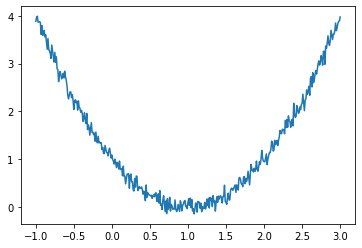

Correlation between X and Y is -0.01
Mutual information=1.79


In [46]:
import numpy as np

X = np.linspace(start = -1, stop = 3, num=401, endpoint=True)
Y = X**2 - 2*X + 1
print("Standard Deviation of Y=%.2f"%np.std(Y))

noise_var = 0.1
noise = np.random.normal(0, noise_var, len(X))
Y += noise
#Y = noise

import matplotlib.pyplot as plt

plt.plot(X, Y)
plt.show()

# Calculation Correlation
corr = np.corrcoef(X, Y)[0, 1]
print("Correlation between X and Y is %.2f"%corr)
# Calculate Mutual Information

from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi = calc_MI(X, Y, 20)
print("Mutual information=%.2f"%mi)

<hr style="border:5px solid gray"> </hr>

## Section 4. Stepwise and Embedded Methods

<hr style="border:5px solid gray"> </hr>

### Stepwise Model Selection

#### Backward model selection

In [43]:
# Recursive Feature Elimination
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE # Recursive Feature Elimination
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

### What is the Friedman #1 Regression problem?

It's a regression problem, where the Y values are generated as follows:

 - For each $x_{i}$, pick a random value between 0 and 1.
 - Plug all x values into the formula to get a y:

$ y(X) = 10 \cdot sin(\pi \cdot x_{0} \cdot x_{1}) + 20 \cdot (x_{2} - 0.5)^2 + 10 \cdot x_{3} + 5 \cdot x_{4} + \textrm{N}(0, 1)_{\textrm{for all i>5}} + \textrm{(noise level)} \cdot \textrm{N}(0, 1)$

The default for `noise level` is zero.

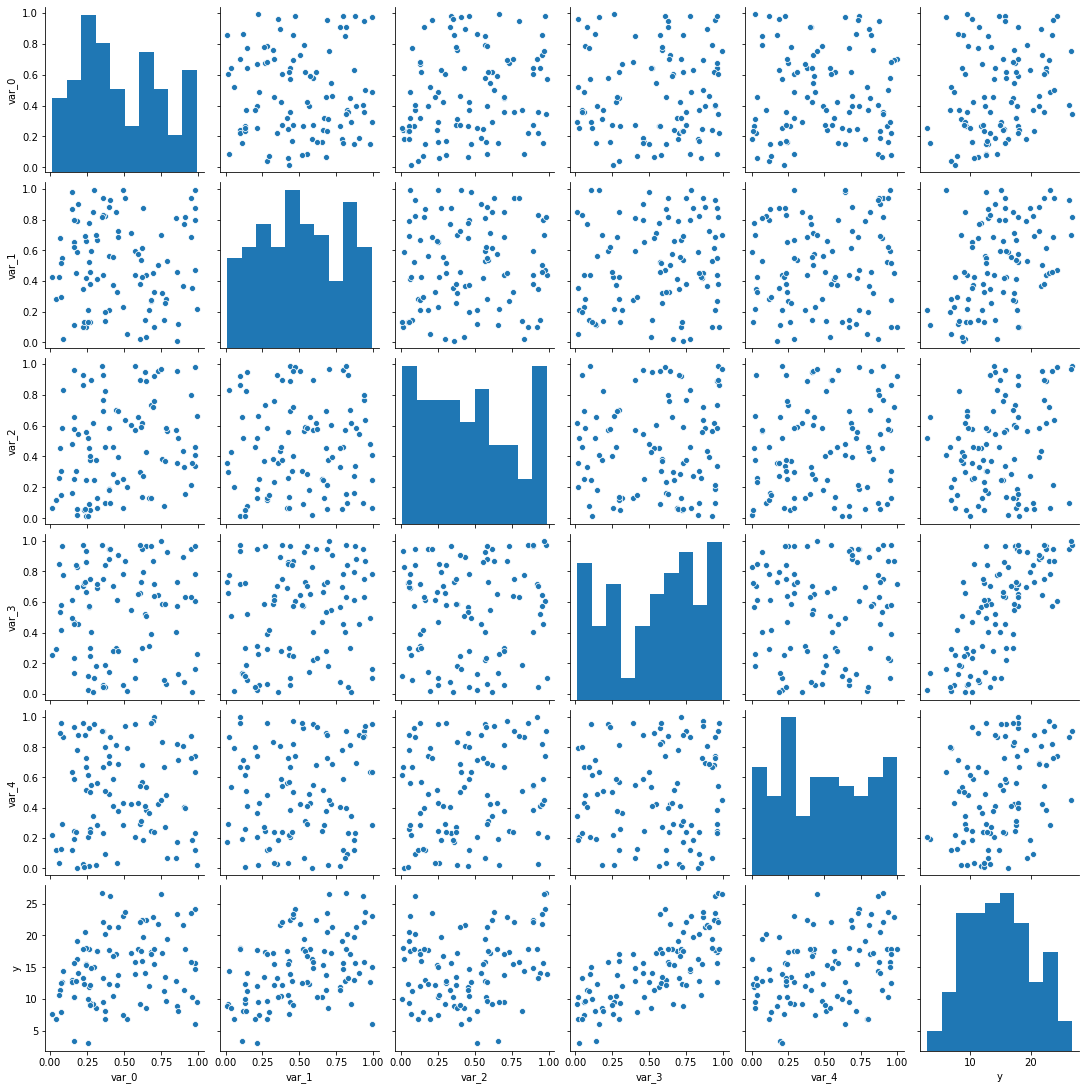

In [50]:
X, y = make_friedman1(n_samples=100, n_features=5, random_state=0)

temp_df = pd.DataFrame.from_records(X, columns=['var_' + str(ix) for ix in range(5)])
temp_df['y'] = y

sns.pairplot(temp_df)

In [59]:
# Use 10 features instead now.
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)

# print out the first 10 rows
print('First 5 rows:')
print(X[0:5,:])
print('\n')

# Select 5 features. Step=1 means each step only remove 1 variable from the model each time.
estimator = LinearRegression()

# Since this is linear regression, we are doing backwards stepwise regression on removing the lowest coefficient.

selector = RFE(estimator, n_features_to_select=5, step=1, verbose=1)
selector = selector.fit(X, y)
print(selector.support_) # The mask of selected features.
print(selector.ranking_) # selected features are ranked.

First 5 rows:
[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
  0.43758721 0.891773   0.96366276 0.38344152]
 [0.79172504 0.52889492 0.56804456 0.92559664 0.07103606 0.0871293
  0.0202184  0.83261985 0.77815675 0.87001215]
 [0.97861834 0.79915856 0.46147936 0.78052918 0.11827443 0.63992102
  0.14335329 0.94466892 0.52184832 0.41466194]
 [0.26455561 0.77423369 0.45615033 0.56843395 0.0187898  0.6176355
  0.61209572 0.616934   0.94374808 0.6818203 ]
 [0.3595079  0.43703195 0.6976312  0.06022547 0.66676672 0.67063787
  0.21038256 0.1289263  0.31542835 0.36371077]]


Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
[ True  True  True  True  True False False False False False]
[1 1 1 1 1 2 3 6 5 4]


> NOTE: Since we are removing features based on a COEFFICIENT VALUE, we assume that our inputs are on the same scale. This is, by chance, a feature of the Friedman # 1 regression data. BUT if not, we have to scale our data based on training data.

In [58]:
# What about selecting down to 1?
selector = RFE(estimator, n_features_to_select=1, step=1, verbose=1)
selector = selector.fit(X, y)
print(selector.support_) # The mask/boolean of selected features.
print(selector.ranking_) # selected features are ranked 1.

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
[False False False  True False False False False False False]
[ 5  4  3  1  2  6  7 10  9  8]


### Install Machine Learning Extensions
See <a href="http://rasbt.github.io/mlxtend/">mlxtend's documentation</a>

In [62]:
# Uncomment the following line to run
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 216 kB/s eta 0:00:01


#### Forward Feature Selection

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.1s finished
Features: 1/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
Features: 2/13

[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
  6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9283e+02
  4.0300e+00]
 [3.2370e-02 0.0000e+00 2.1800e+00 0.0000e+00 4.5800e-01 6.9980e+00
  4.5800e+01 6.0622e+00 3.0000e+00 2.2200e+02 1.8700e+01 3.9463e+02
  2.9400e+00]
 [6.9050e-02 0.0000e+00 2.1800e+00 0.0000e+00 4.5800e-01 7.1470e+00
  5.4200e+01 6.0622e+00 3.0000e+00 2.2200e+02 1.8700e+01 3.9690e+02
  5.3300e+00]
 [2.9850e-02 0.0000e+00 2.1800e+00 0.0000e+00 4.5800e-01 6.4300e+00
  5.8700e+01 6.0622e+00 3.0000e+00 2.2200e+02 1.8700e+01 3.9412e+02
  5.2100e+00]
 [8.8290e-02 1.2500e+01 7.8700e+00 0.0000e+00 5.2400e-01 6.0120e+00
  6.6600e+01 5.5605e+00 5.0000e+

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished
Features: 3/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
Features: 4/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished
Features: 5/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
Features: 6/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished
Features: 7/13[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished
Features: 8/13[Parallel(

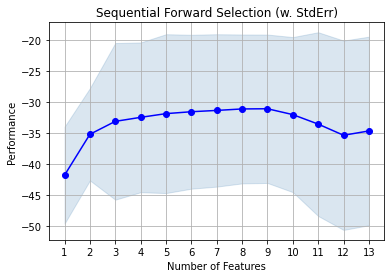

In [64]:
# Forward Stepwise Feature Selection
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Boston dataset
boston = load_boston()
X, y = boston.data, boston.target

print(X[0:10, :])
# Linear Regression
lr = LinearRegression()

sfs = SFS(lr, 
          k_features=13, # k_features has to be smaller or equal to the number of features. If equal to, it starts from
                         # intercept to the full model
          forward=True,  # forward
          scoring='neg_mean_squared_error',
          cv=10,
          verbose=1)

sfs = sfs.fit(X, y)
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

### Get the Best Model

In [68]:
# 8th or 9th is the best:
sfs.get_metric_dict()[8]

{'feature_idx': (0, 1, 3, 4, 5, 7, 10, 12),
 'cv_scores': array([  -9.72892743,  -14.58689072,  -12.01189155,  -37.33502852,
         -30.34743059,  -21.26868648,   -9.78483232, -135.22686925,
         -30.70389754,  -10.60860571]),
 'avg_score': -31.160306011122895,
 'feature_names': ('0', '1', '3', '4', '5', '7', '10', '12'),
 'ci_bound': 26.72385759732009,
 'std_dev': 35.98140785582507,
 'std_err': 11.993802618608354}

In [74]:
# Get the actual names:
# Get column indices.
col_names = sfs.get_metric_dict()[8]['feature_idx']

# Use column indicies to get boston's feature names.
real_names = [boston['feature_names'][c] for c in col_names]
print(real_names)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']


### LASSO and Ridge Regression

In [75]:
# LASSO
from sklearn import linear_model

alpha = 0.5 # Increasing alpha can shrink more variable coefficients to 0
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X, y)

print(clf.coef_)

print(clf.intercept_)



[-0.0832894   0.04954355 -0.0052532   0.         -0.          2.49821246
  0.00360438 -0.93660469  0.27745115 -0.01544219 -0.75875211  0.00946855
 -0.6562895 ]
32.52086096257654


In [106]:
# Try varying alpha
alpha_seq = np.linspace(0.01, 4.0, 50)
num_coefs = X.shape[1]

# Store coefficients for each alpha:
coef_cols = ['coef_' + str(ix) for ix in range(num_coefs)] + ['intercept']
alpha_df = pd.DataFrame(columns=coef_cols)

for a in alpha_seq:
    # Fit model
    clf_temp = linear_model.Lasso(alpha=a)
    clf_temp.fit(X, y)
    # Get coefficients + intercept
    coef_nums = np.append(clf_temp.coef_, clf_temp.intercept_)

    alpha_df = alpha_df.append(dict(zip(coef_cols, coef_nums)), ignore_index=True)

alpha_df.index = alpha_seq
alpha_df.head()

,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8,coef_9,coef_10,coef_11,coef_12,intercept
0.010000,-0.106228,0.046860,0.006474,2.504190,-14.394478,3.814186,-0.001818,-1.422155,0.298526,-0.012627,-0.916369,0.009485,-0.530481,34.219723
0.091429,-0.097981,0.049168,-0.038189,1.092076,-0.000000,3.727913,-0.010514,-1.165122,0.273639,-0.014491,-0.769072,0.010249,-0.566387,25.399131
0.172857,-0.096756,0.049536,-0.024922,0.000000,-0.000000,3.490212,-0.006175,-1.120354,0.282074,-0.015142,-0.780810,0.010219,-0.588318,27.034990
0.254286,-0.093368,0.049670,-0.020377,0.000000,-0.000000,3.237608,-0.002837,-1.069201,0.281087,-0.015229,-0.775172,0.010023,-0.606571,28.376853
0.335714,-0.089999,0.049730,-0.015641,0.000000,-0.000000,2.988181,-0.000000,-1.021045,0.280005,-0.015309,-0.769617,0.009832,-0.624082,29.731631


In [107]:
alpha_df.tail()

,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8,coef_9,coef_10,coef_11,coef_12,intercept
3.674286,-0.0,0.040394,-0.0,0.0,0.0,0.0,0.040393,-0.0,0.0,-0.006963,-0.063444,0.006055,-0.794351,31.208682
3.755714,-0.0,0.040809,-0.0,0.0,0.0,0.0,0.040141,-0.0,0.0,-0.007101,-0.040977,0.006043,-0.792416,30.842865
3.837143,-0.0,0.041290,-0.0,0.0,0.0,0.0,0.039943,-0.0,0.0,-0.007241,-0.018217,0.006029,-0.790544,30.469342
3.918571,-0.0,0.041591,-0.0,0.0,0.0,0.0,0.039635,-0.0,0.0,-0.007360,-0.000000,0.006023,-0.788387,30.173993
4.000000,-0.0,0.041348,-0.0,0.0,0.0,0.0,0.039030,-0.0,0.0,-0.007383,-0.000000,0.006043,-0.785279,30.181474


(-1.5, 1.5)

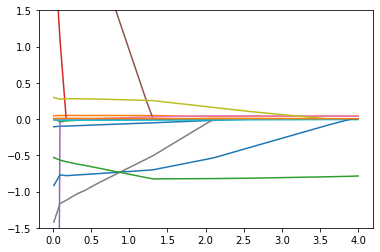

In [113]:
non_intercept_cols = [c for c in alpha_df.columns if c not in ['intercept']]
ax1 = alpha_df[non_intercept_cols].plot.line(legend=None)
ax1.set_ylim(-1.5, 1.5)

In [114]:
# Ridge Regression
from sklearn import linear_model
alpha = 10 
clf = linear_model.Ridge(alpha=alpha)
clf.fit(X, y)

print(clf.coef_)

print(clf.intercept_)

import numpy as np
# Increasing alpha can compress the L2 norm of the coefficients to 0 (but not selecting variables)
print("Sum of square of coefficients = %.2f"%np.sum(clf.coef_**2)) 

[-0.10143535  0.0495791  -0.0429624   1.95202082 -2.37161896  3.70227207
 -0.01070735 -1.24880821  0.2795956  -0.01399313 -0.79794498  0.01003684
 -0.55936642]
27.467884964141266
Sum of square of coefficients = 25.74


In [119]:
# Try varying alpha
alpha_seq = np.linspace(0.01, 20.0, 50)
num_coefs = X.shape[1]

# Store coefficients for each alpha:
coef_cols = ['coef_' + str(ix) for ix in range(num_coefs)] + ['intercept']
alpha_df = pd.DataFrame(columns=coef_cols)

for a in alpha_seq:
    # Fit model
    clf_temp = linear_model.Ridge(alpha=a)
    clf_temp.fit(X, y)
    # Get coefficients + intercept
    coef_nums = np.append(clf_temp.coef_, clf_temp.intercept_)

    alpha_df = alpha_df.append(dict(zip(coef_cols, coef_nums)), ignore_index=True)

alpha_df.index = alpha_seq
alpha_df.head()

,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8,coef_9,coef_10,coef_11,coef_12,intercept
0.010000,-0.107954,0.046436,0.020076,2.685010,-17.652142,3.810767,0.000590,-1.473880,0.305781,-0.012344,-0.951478,0.009318,-0.524885,36.378324
0.417959,-0.106140,0.046959,0.004610,2.623059,-13.977888,3.837260,-0.002654,-1.419759,0.297265,-0.012640,-0.910917,0.009509,-0.529139,33.794240
0.825918,-0.104973,0.047319,-0.005491,2.572040,-11.569449,3.850690,-0.004740,-1.384310,0.291867,-0.012843,-0.884636,0.009633,-0.532237,32.134307
1.233878,-0.104168,0.047589,-0.012595,2.527474,-9.868829,3.856843,-0.006178,-1.359299,0.288208,-0.012993,-0.866334,0.009719,-0.534686,30.990788
1.641837,-0.103584,0.047804,-0.017855,2.487167,-8.603980,3.858538,-0.007218,-1.340710,0.285616,-0.013110,-0.852938,0.009783,-0.536732,30.164901


In [120]:
alpha_df.tail()

,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8,coef_9,coef_10,coef_11,coef_12,intercept
18.368163,-0.101600,0.050526,-0.046781,1.623985,-1.373842,3.514559,-0.009701,-1.231989,0.284444,-0.014385,-0.798268,0.010005,-0.575015,28.345544
18.776122,-0.101612,0.050566,-0.046891,1.610927,-1.346202,3.505730,-0.009639,-1.231437,0.284694,-0.014401,-0.798450,0.010002,-0.575711,28.398213
19.184082,-0.101625,0.050605,-0.046997,1.598089,-1.319650,3.496936,-0.009576,-1.230897,0.284944,-0.014416,-0.798639,0.009999,-0.576402,28.451207
19.592041,-0.101637,0.050645,-0.047100,1.585463,-1.294122,3.488179,-0.009513,-1.230369,0.285193,-0.014432,-0.798834,0.009996,-0.577088,28.504486
20.000000,-0.101650,0.050683,-0.047200,1.573044,-1.269559,3.479459,-0.009449,-1.229852,0.285442,-0.014447,-0.799034,0.009994,-0.577769,28.558011


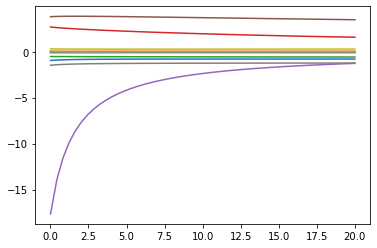

In [122]:
non_intercept_cols = [c for c in alpha_df.columns if c not in ['intercept']]
ax1 = alpha_df[non_intercept_cols].plot.line(legend=None)
#ax1.set_ylim(-1.5, 0.5)